## 1. Importing Libra and other dependencies <a name="import"></a>

Import Libra and other dependencies such as numpy and matplotlib

In [1]:
import os
import sys
import time
import math

# Fisrt, we add the location of the library to test to the PYTHON path
from liblibra_core import *
from libra_py import units
import libra_py.workflows.nbra.lz as lz
import libra_py.workflows.nbra.step4 as step4
from libra_py import data_visualize
from libra_py import data_conv, data_stat, data_outs, data_read
from libra_py import pdos, spectrum
from libra_py import fit
import libra_py.workflows.nbra.decoherence_times as decoherence_times
from libra_py import influence_spectrum

import numpy as np
import matplotlib.pyplot as plt

colors = {}
colors.update({"1": '#000000'})  # Black 
colors.update({"2": '#000099'})  # Blue  
colors.update({"3": '#006400'})  # Green 
colors.update({"4": '#990000'})  # Red   
colors.update({"5": '#8B008B'})  # Purple
colors.update({"6": '#FF8C00'})  # Orange
colors.update({"9": '#4d4d4d'})  # Gray  
color_index = ["1","2","3","4","5","6","9"]


colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

clrs_index = ["11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24",
              "11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24",
              "11", "21", "31", "41", "12", "22", "32", "13","23", "14", "24"  ]


/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/home/alexey/Conda/Miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::v

Define auxiliary functions for this script

In [2]:
def plot_hvib(Hvib, figname='energies_nacs-1.png'):

    ntraj  = len(Hvib)
    nsteps = len(Hvib[0])
    nCIs   = Hvib[0][0].num_of_cols

    # Make a list for the SD energies and populate it
    CI_energy = []
    md_time = list( range(nsteps) )
    for sd_index in range( nCIs ):
        CI_energy.append( [] )
        for step in range( nsteps ):        
            En = Hvib[0][step].get( sd_index, sd_index ).real 
            E0 = Hvib[0][step].get( 0, 0 ).real
            CI_energy[ sd_index ].append( En - E0 )        
        
    CI_energy  = np.array( CI_energy  )
    md_time    = np.array( md_time )

    # Compute the time-averaged CI NACs and make a list of them
    ci_res = data_stat.cmat_stat2(Hvib[0], 2)
    ci_tNACs = []
    for i in range(nCIs):
        ci_tNACs.append( [] )
        for j in range(nCIs):
            ci_tNACs[i].append( ci_res.get(i,j).imag * 1000.0 / units.ev2Ha )        
    ci_tNACs = np.array(ci_tNACs)

    nstates = 15

    # Figures - Time-Dependent Data
    plt.figure(num=None, figsize=(6.42, 2.41), dpi=300, edgecolor='black', frameon=True)
    plt.subplot(1,2,1)
    plt.ylim(0,2)
    plt.title('TD-DFT Energies', fontsize=8)
    plt.xlabel('Time, fs')
    plt.ylabel('$E-E_0$, eV')
    for state in range( nstates ):    
        if state==1:
            plt.plot(md_time, CI_energy[state]/units.ev2Ha, label="", linewidth=2, color = "red")
        elif state==2:
            plt.plot(md_time, CI_energy[state]/units.ev2Ha, label="", linewidth=2, color = "blue")            
        else:
            plt.plot(md_time, CI_energy[state]/units.ev2Ha, label="", linewidth=1, color = "black")
    plt.tight_layout()


    plt.subplot(1,2,2)
    plt.title('TD-DFT time-averaged NACs', fontsize=8)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlim(0,nstates-1)
    plt.ylim(0,nstates-1)
    #plt.xticks([0,1,2,3,4,5,6,7,8,9])
    #plt.yticks([0,1,2,3,4,5,6,7,8,9])
    plt.xlabel('State index')
    plt.ylabel('State index')
    plt.imshow(ci_tNACs, cmap='hot', interpolation='nearest')
    cb = plt.colorbar(label="meV")
    cb.ax.tick_params(labelsize=8)

    plt.tight_layout()

    plt.savefig(figname, dpi=600)
    plt.show()


def get_avegage_energies(Hvib):
        
    nsteps = len(Hvib[0])
    nstates   = Hvib[0][0].num_of_cols

    # Make a list for the SD energies and populate it
    dE = [0.0]*nstates
        
    for step in range( nsteps ):
        for i in range( nstates ):
            dE[i] += Hvib[0][step].get( i, i ).real - Hvib[0][step].get( 0, 0 ).real 
            
    for i in range( nstates ):
        dE[i] = dE[i] / nsteps
        
    return dE


## 2. pDOS

In [3]:
# pDOS calculations
s_proj = [ ["s"], [], ["P"] ]
p_proj = [ ["px", "py", "pz"], [], ["P"] ]
d_proj = [ ["d-2", "d-1", "d0", "d+1", "d+2"], [], ["P"] ]

pdos_params = {"prefix": "all_pdosfiles/pristine", 
               "snapshots": list(range(5000, 7000)) , 
               "projections":[ s_proj, p_proj, d_proj ], 
               "element_mapping": {"P":1}     
              }
E, pDOSa, pDOSb = pdos.cp2k_pdos( pdos_params )


multiplication factor is =  4
original grid spacing =  0.1
new grid spacing =  0.025
gaussian variance =  0.05
multiplication factor is =  4
original grid spacing =  0.1
new grid spacing =  0.025
gaussian variance =  0.05


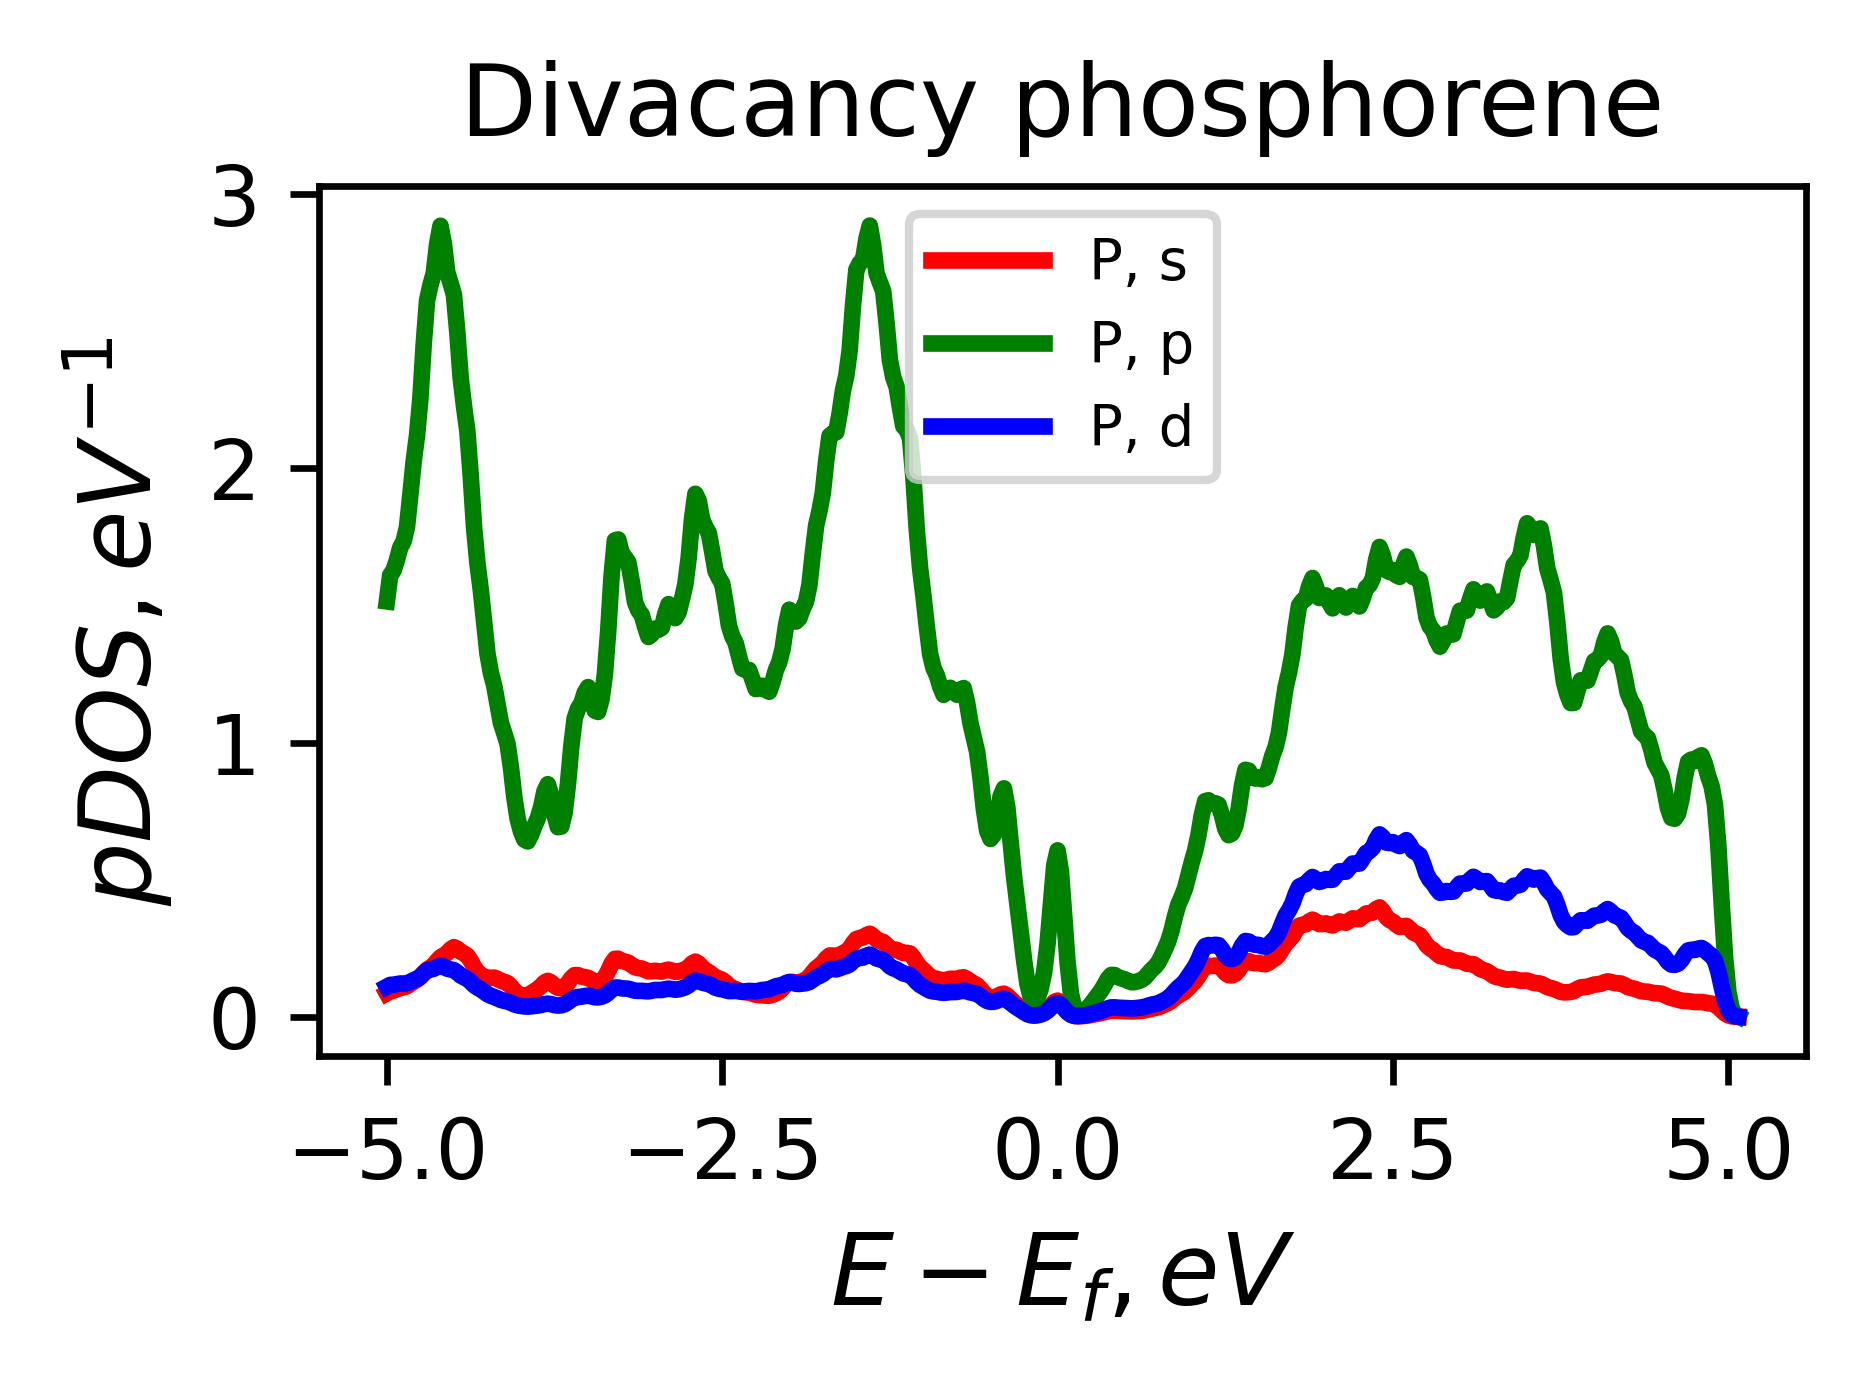

In [5]:
# Plotting
plotting_params = { "which_projections": [ 0, 1, 2],
                    "labels": ["P, s", "P, p", "P, d"], 
                    "colors": ["red", "green", "blue"],
                    "title": "Divacancy phosphorene" 
                  }
                
pdos.pdos_plot(plt, E, pDOSa, pDOSb, plotting_params )

## 3. Optical spectrum

In [6]:
spec_params = {"prefix":"all_logfiles/step_",
               "snapshots": list(range(5000, 6999)),
               "states":list(range(1,16)),
               "emin":0.0, "emax":2.0, "de":0.1,
               "outfile_prefix":"absorption_", 
               "do_convolve":True, "de_new":0.025, "var": 0.05
               }
e, spec = spectrum.cp2k_spectrum(spec_params)

multiplication factor is =  4
original grid spacing =  0.1
new grid spacing =  0.025
gaussian variance =  0.05


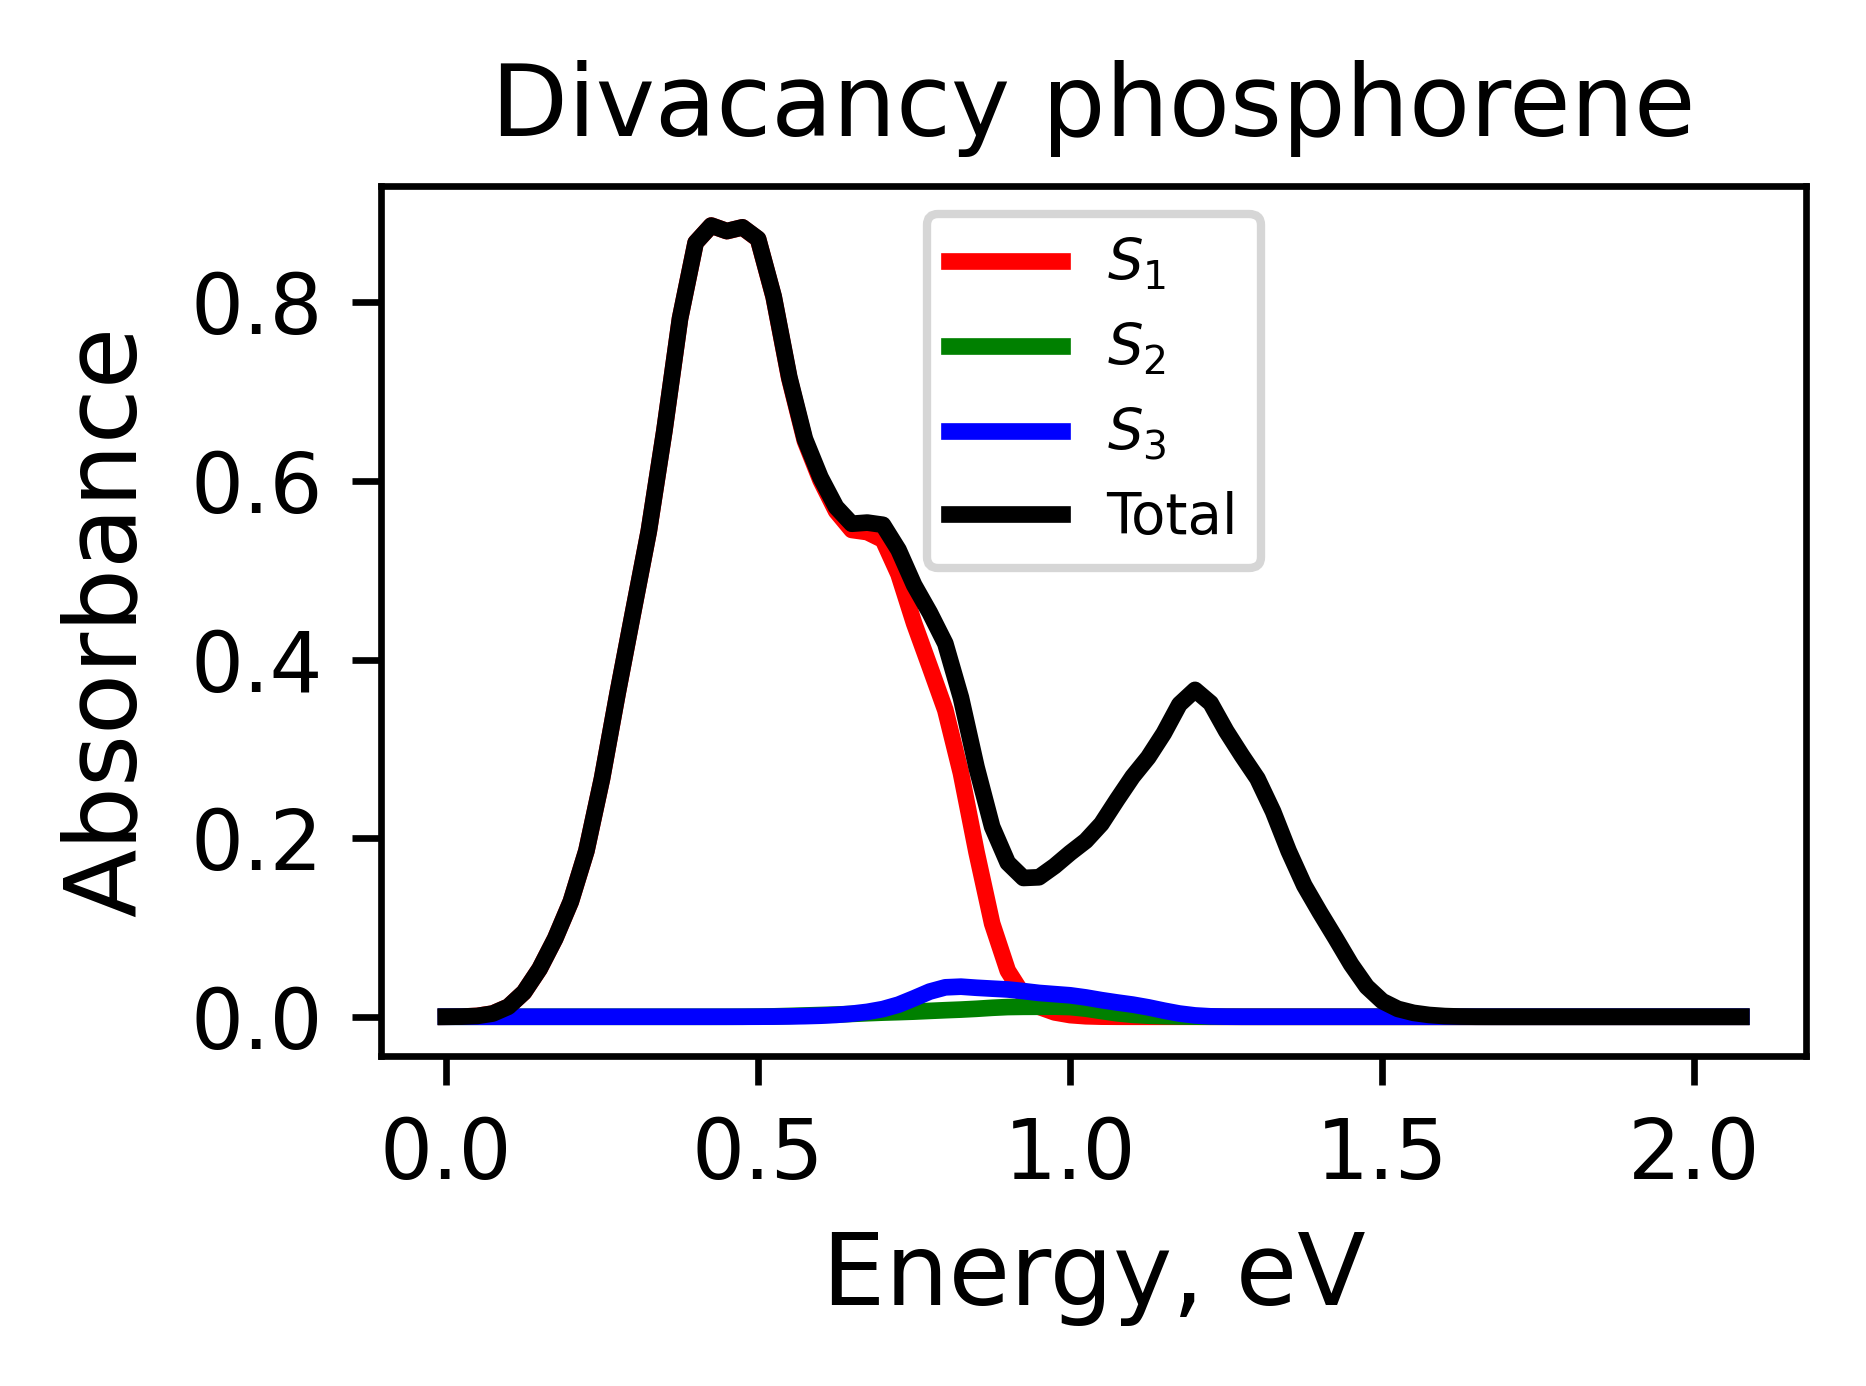

In [9]:
# Plotting
plotting_params = { "which_projections": [0, 1, 2, 15],
                    "labels": ["$S_1$", "$S_2$", "$S_3$", "Total"], 
                    "colors": ["red", "green", "blue", "black"],
                    "title": "Divacancy phosphorene", "output_prefix":"spectrum_divac"
                  }
                
spectrum.spectrum_plot(plt, e, spec, plotting_params )

## 4.  Read in the Hvib data<a name="read"></a>
[Return to Table of contents](#toc)

In [10]:
print ("\nGathering data from MD ")
print ("Considering system", "Libra Tutorial: Single Rutile TiO2 Unit Cell - Kohn-Sham basis")

absolute_path = os.getcwd()
params = {}
params["data_set_paths"] = []
params["data_set_paths"].append(absolute_path+"/res_mb_sp/")

params["Hvib_re_prefix"] = "Hvib_ci_"; params["Hvib_re_suffix"] = "_re"
params["Hvib_im_prefix"] = "Hvib_ci_"; params["Hvib_im_suffix"] = "_im"
params["nfiles"]         = 1999
params["init_times"]     = [5000]
params["nstates"]        = 16 # total number of electronic states
params["active_space"]   = list(range(16)) # indexing is from 0!

# Include HOMO and up to the last electronic state
hvib = step4.get_Hvib2(params)
print ("Length of hvib is: ", len(hvib[0]))


Gathering data from MD 
Considering system Libra Tutorial: Single Rutile TiO2 Unit Cell - Kohn-Sham basis
Length of hvib is:  1999


### 4.1. Check data retrieval <a name="sanity_ks"></a>
[Return to Table of contents](#toc)

We need to print an element of hvib to see if we have anything meaningful. A lot of times, when i run this I somehow don't read the data correctly. When the data is read incorrectly, the hvib lists will contain matrices full of 0's. So, let's print some matrix elements of hvib[0] to see if we get non-zero values. If these values happen to turn up all zero, you should reconsider the paths to your hvib files and their names. There is also the possibility that the values you see here are non-zero, yet incorrect. This may happen if your pathing is correcting but you do not have the correct number for the parameter, nstates. Please double check these printed values with the values in the actual hvib files to see if they match.

In [11]:
#Print the matrix elements: 0,0 1,1  0,1 0,2 . 
# The matrix elemnts are extracted with the .get() feature

print ( "\n Test, for energies")
print ( "GS = ",   ( hvib[0][0].get(0,0) ).real / units.ev2Ha, " eV" )
print ( "S1 = ",   ( hvib[0][0].get(1,1) ).real / units.ev2Ha, " eV" )


 Test, for energies
GS =  0.0  eV
S1 =  0.6027600038959999  eV


### 4.2. Visualize the original data

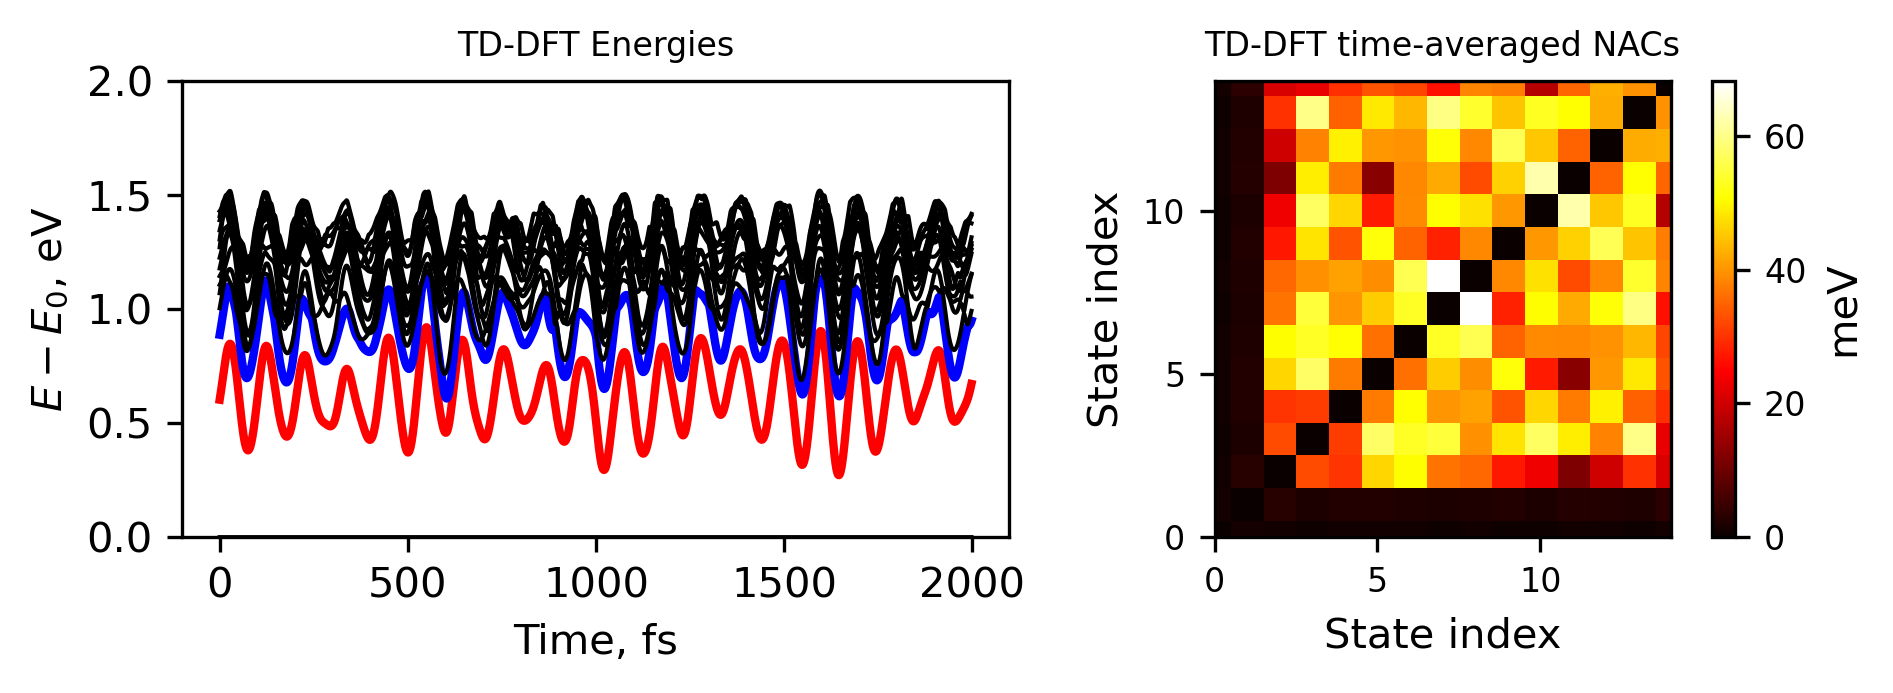

In [12]:
plot_hvib(hvib, 'energies_nacs-original.png')

### 4.3. Compute decoherence times and average gaps in the original basis<a name="decoherence"></a>
[Return to Table of contents](#toc)

In [13]:
params["init_times"] = [0]
params["nsteps"] = 1999
# Compute energy gaps and decoherence times over part of the trajectory we want
tau, rates = decoherence_times.decoherence_times_ave(hvib, [params["init_times"][0]], params["nsteps"], 0)
de         = decoherence_times.energy_gaps_ave(      hvib, [params["init_times"][0]], params["nsteps"])
avg_deco   = tau/units.fs2au


In [14]:
print ("Decoherence time for GS / S1 =", tau.get(0,1)/units.fs2au, "fs")
params["decoherence_constants"] = 1
params["decoherence_times"]     = tau

Decoherence time for GS / S1 = 6.710385607416499 fs


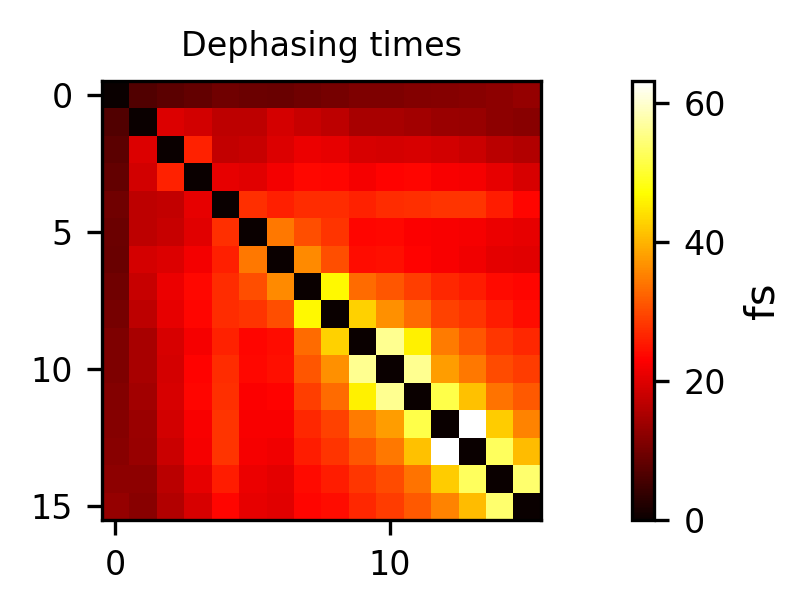

In [16]:
tau_ci = data_conv.MATRIX2nparray( tau ) * units.au2fs
for i in range( len(tau_ci) ):
    tau_ci[i][i] = 0.0
    
data = [tau_ci]
subplot_titles = [ "Dephasing times" ]
data_visualize.plot_map_nparray( plt, data, fig_width=6.42, fig_height=2.14, titles=subplot_titles, \
                                 title_size=8, num_subplots=1, colormap='hot', \
                                 interpolation_scheme='nearest', colorbar_label='fs',
                                 savefig=1, figure_names=['dephasing_times.png'] )

### 4.4. Average gaps and gap distributions

In [17]:
dE = get_avegage_energies(hvib)

print("Average energies above the GS are")
for indx, e_gap in enumerate(dE):
    print(F"State {indx} energy {e_gap * units.au2ev} eV")

Average energies above the GS are
State 0 energy 0.0 eV
State 1 energy 0.6219166930167962 eV
State 2 energy 0.9021793694558063 eV
State 3 energy 0.9745178790418609 eV
State 4 energy 1.0427597922749183 eV
State 5 energy 1.0985573936604647 eV
State 6 energy 1.1453156679234595 eV
State 7 energy 1.1867324985164258 eV
State 8 energy 1.2217149223014407 eV
State 9 energy 1.2570270412052567 eV
State 10 energy 1.2850834989132482 eV
State 11 energy 1.309561077979356 eV
State 12 energy 1.3335040644170524 eV
State 13 energy 1.3560656727195517 eV
State 14 energy 1.3843975537309254 eV
State 15 energy 1.4094931994898472 eV


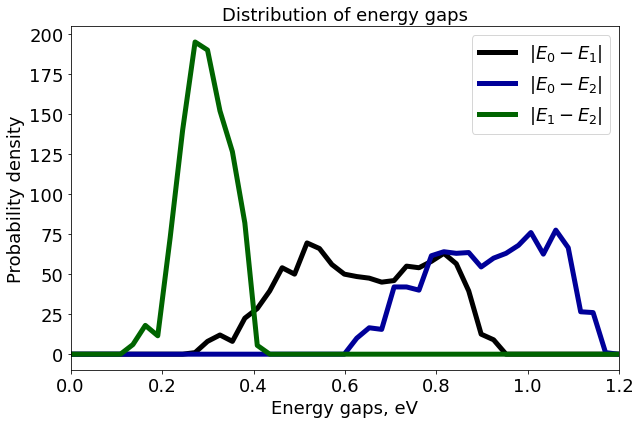

In [18]:
states = [0, 1, 2]
nst = len(states)

plt.figure(1, figsize=(9, 6)) # dpi=300, frameon=False)
plt.subplot(1,1,1)
plt.title('Distribution of energy gaps', fontsize=18)
plt.xlabel('Energy gaps, eV', fontsize=18)
plt.ylabel('Probability density', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlim(0,1.2)
#plt.ylim(0,nstates-1)
    
cnt = 0
for i in range(nst):
    st1 = states[i]
    for j in range(i+1, nst):
        st2 = states[j]        
        bin_supp, dens, cum = data_stat.cmat_distrib(de, st1, st2, 0, 0.0, 0.05, 0.001) 
        
        plt.plot( np.array(bin_supp) * units.au2ev, dens, label=F'$|E_{st1}-E_{st2}|$', 
                 linewidth=5, color = colors[color_index[cnt]])     
        cnt = cnt + 1
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig("energy_gap_distrib.png", dpi=600)
plt.show()
plt.close()



### 4.5. Influence spectrum

In [19]:
infsp_params = {}
infsp_params["dt"] = 1.0        # MD timestep in fs
infsp_params["wspan"] = 500.0  #  cm^-1
infsp_params["dw"] = 1.0        # cm^-1
infsp_params["do_output"] = False
infsp_params["do_center"] = True
infsp_params["acf_type"] = 0
infsp_params["data_type"] = 0


states = [0, 1, 2]
nst = len(states)

T, ACF, W, J2 = [], [], [], []
for i in range(nst):
    for j in range(i+1,nst):
        
        data_ij = []        
        for de_ij in de:
            x = MATRIX(1,1)
            x.set(0,0, de_ij.get(i,j))
            data_ij.append(x)

        Tij, ACFij, uACFij, Wij, Jij, J2ij = influence_spectrum.recipe1(data_ij, infsp_params)
        
        T.append(Tij)
        ACF.append(ACFij)
        W.append(Wij)
        J2.append(J2ij)


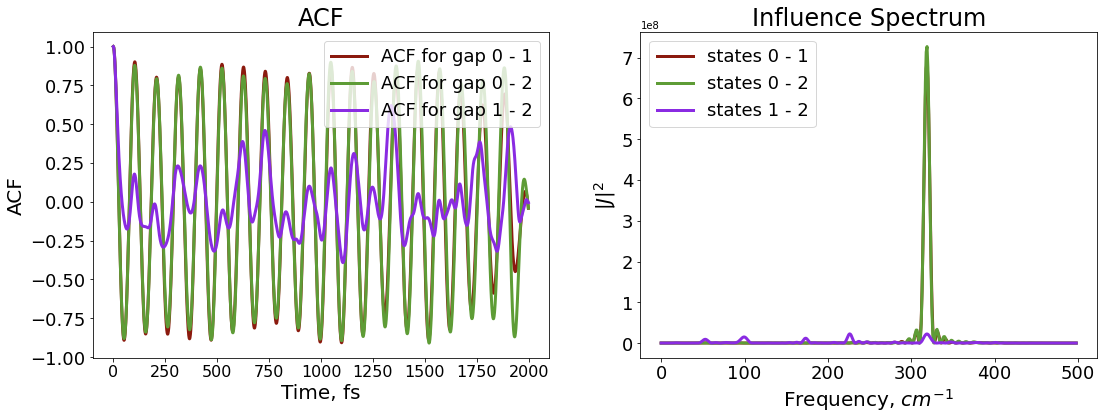

In [20]:
plt.figure(1, figsize=(18, 6)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.title('ACF', fontsize=24)
plt.xlabel('Time, fs', fontsize=20)
plt.ylabel('ACF', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=18)

count = 0
for i in range(nst):
    st1 = states[i]
    for j in range(i+1,nst):
        st2 = states[j]
        
        plt.plot(T[count], ACF[count], label='ACF for gap %i - %i' % (st1, st2), 
                 linewidth=3, color = colors[clrs_index[count]]) 
        count = count + 1
plt.legend(fontsize=18)

plt.subplot(1,2,2)
plt.title('Influence Spectrum',fontsize=24)
plt.xlabel('Frequency, $cm^{-1}$',fontsize=20)
plt.ylabel('$|J|^2$',fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

count = 0
for i in range(nst):
    st1 = states[i]
    for j in range(i+1,nst):
        st2 = states[j]        
        plt.plot(W[count], J2[count], label=F'states {st1} - {st2}', 
                 linewidth=3, color = colors[clrs_index[count]]) 
        count = count + 1
plt.legend(fontsize=18)

plt.savefig("acf-IFS.png", dpi=600)
plt.show()
plt.close()